# Introduction to Conditional Density Estimation

<br/>

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [134]:
import math

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import pi
from torch.utils import data
import numpy as np
from torch import tensor
torch.manual_seed(0)

### Example problem:
Generate data from $x = t + 0.3 \sin(2 \pi t) + \epsilon$

In [3]:
# generate data
n = 4000
d = 1
t = 1

In [4]:
t_train = torch.rand((n, d))

noise = torch.rand((n, d)) * 0.2 - 0.1 # uniform in [-0.1, 0.1]
x_train = t_train + 0.3*torch.sin(2*pi*t_train) + noise

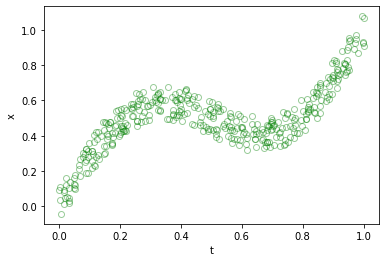

In [5]:
# Data t_train and x_train
fig = plt.figure(figsize=(6, 4))
plt.plot(t_train[:400], x_train[:400], 'go', alpha=0.4, markerfacecolor='none')
plt.xlabel('t')
plt.ylabel('x')
plt.savefig("data0.png", dpi=200)
plt.show()

<img src="./data0.png" alt="drawing" width="400"/> 

In [6]:
def train(x, y):
    dataset = data.TensorDataset(x, y)
    train_loader = data.DataLoader(
        dataset,
        batch_size=20,
    )
    
    net = nn.Sequential(
        nn.Linear(1, 20),
        nn.ReLU(),
        nn.Linear(20, 20),
        nn.ReLU(),
        nn.Linear(20, 1),
    )
    
    opt = optim.Adam(net.parameters(), lr=0.01)
    for e in range(400):
        for x, y in train_loader:
            opt.zero_grad()
            out = net(x)
            loss = F.mse_loss(out, y)
            loss.backward()
            opt.step()
            
    return net

In [8]:
# net = train(t_train, x_train)

In [9]:
# torch.save(net, 'forward_net')

In [11]:
net = torch.load('nets/forward_net')

In [12]:
t_test = torch.linspace(0, 1, 100).unsqueeze(1)
out = net(t_test)

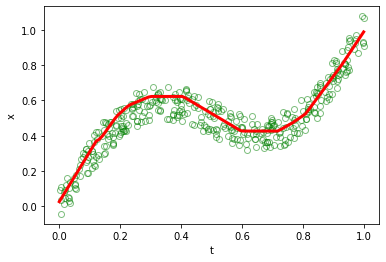

In [13]:
# plot
fig = plt.figure(figsize=(6, 4))
plt.plot(t_train[:400], x_train[:400], 'go', alpha=0.5, markerfacecolor='none')
plt.plot(t_test, out.data, 'r', linewidth=3.0)
plt.xlabel('t')
plt.ylabel('x')
# plt.savefig("data0_fit.png", dpi=200)
plt.show()

Let's look at the neural network predictions:

<img src="./data0_fit.png" alt="drawing" width="400"/> 

The neural network captures the data very well.

## Predict the inverse
Again, generate data from $x = t + 0.3 \sin(2 \pi t) + \epsilon$. But now, predict $t$ from $x$.

In [14]:
t_train_inv = x_train
x_train_inv = t_train

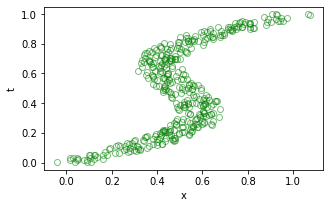

In [15]:
fig = plt.figure(figsize=(5, 3))
plt.plot(t_train_inv[:400], x_train_inv[:400], 'go', alpha=0.5, markerfacecolor='none')
plt.xlabel('x')
plt.ylabel('t')
# plt.savefig("data1.png", dpi=200)
plt.show()

<img src="./data1.png" alt="drawing" width="400"/> 

In [20]:
# net = train(t_train_inv, x_train_inv)

In [21]:
# torch.save(net, 'nets/inverse_net')

In [22]:
net = torch.load('nets/inverse_net')

In [23]:
t_test_inv = torch.linspace(-0.1, 1.1, 500).unsqueeze(1)
out = net(t_test_inv)

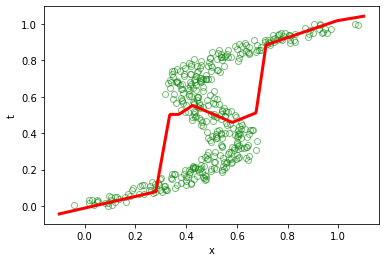

In [25]:
# plot
fig = plt.figure(figsize=(6, 4))
plt.plot(t_train_inv[:400], x_train_inv[:400], 'go', alpha=0.5, markerfacecolor='none')
plt.plot(t_test_inv, out.data, 'r', linewidth=3.0)
plt.xlabel('x')
plt.ylabel('t')
# plt.savefig("data1_fit.png", dpi=200)
plt.show()

Again, let's look at the prediction of the NN:
<img src="./data1_fit.png" alt="drawing" width="400"/> 

The neural network can't capture the data well.

## Summary: inverse problems
<br/>
- In many systems, different inputs can lead to the same output.<br/>
<br/>
- When one tries to predict the **inputs from the outputs** (i.e. the inverse function), classical MSE losses fail.<br/>

## Famous example from neuroscience
Prinz, Bucher, and Marder showed in 2004 (Nature Neuroscience) that similar network activity (top) can arise from different parameters (bar heights at bottom).

<img src="./full_lobster_fig.png" alt="drawing" width="800"/>

Neural networks trained to predict parameters from the activity would fail to capture this variability and, as we will see later, would predict the **conditional mean** of the parameters.


## What's going on here? An intro to density estimation.

In [26]:
from torch.distributions import Normal

In [27]:
mean = 1.0
var = 0.4

normal_dist = Normal(mean, var)
samples = normal_dist.sample((20,))

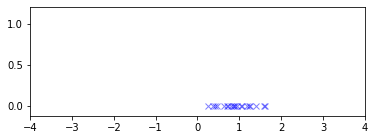

In [29]:
fig = plt.figure(figsize=(6, 2))
plt.plot(samples, np.zeros_like(samples), 'bx', alpha=0.5, markerfacecolor='none')
_ = plt.xlim([-4, 4]); _ = plt.ylim([-0.12, 1.2])
# plt.savefig("samples.png", dpi=200)

In [30]:
x = torch.linspace(-4, 4, 100)
probs = torch.exp(normal_dist.log_prob(x))

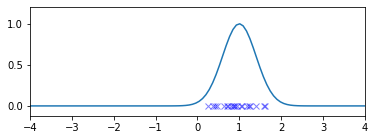

In [32]:
fig = plt.figure(figsize=(6, 2))
plt.plot(samples, np.zeros_like(samples), 'bx', alpha=0.5, markerfacecolor='none')
plt.plot(x, probs)
_ = plt.xlim([-4, 4]); _ = plt.ylim([-0.12, 1.2])
# plt.savefig("fitted_samples.png", dpi=200)

Let's say we have some datapoints in 1D:
<img src="./samples.png" alt="drawing" width="400"/>  

Our goal is to estimate the underlying distribution of these samples:
<img src="./fitted_samples.png" alt="drawing" width="400"/>  

One can do so by  
1) making an assumption about the distribution of that the data. E.g. we choose a normal distribution.  
2) estimating the parameters of the distribution, e.g. mean $\mu$ and standard deviation $\sigma$.

How can we learn $\mu$ and $\sigma$? Maximum likelihood estimation:<br/>  
$L = -\sum_i q(t_i) = -\sum_i N(t_i; \mu, \sigma)$  
<br/>  

The minimum of $L$ stays the same when we take the logarithm. So, we can also minimize:<br/>  
$L = -\sum_i \log N(t_i; \mu(x_i), \sigma(x_i))$  

## Conditional density estimation
The goal is to estimate parameters of a conditional distribution:
<img src="./Gaussian_estimation.png" alt="drawing" width="300"/>  
We now assume a **conditional** Gaussian distribution:  
$L = -\sum_i \log q(t_i|x_i) = -\sum_i \log N(t_i; \mu(x_i), \sigma(x_i))$  

In [33]:
s = torch.tensor([2.0]) # Standard deviation, assumed.

def train(x, y):
    dataset = data.TensorDataset(x, y)
    train_loader = data.DataLoader(
        dataset, batch_size=20)
    
    net = nn.Sequential(
        nn.Linear(1, 20), nn.ReLU(),
        nn.Linear(20, 20), nn.ReLU(),
        nn.Linear(20, 1))
    
    opt = optim.Adam(net.parameters(), lr=0.01)
    for e in range(400):
        for x, y in train_loader:
            opt.zero_grad()
            out = net(x)
            prob_Gauss = 1/torch.sqrt(2*pi*s**2) * torch.exp(-.5/s**2*(out-y)**2)
            loss = -torch.log(prob_Gauss).sum()
            loss.backward()
            opt.step()
            
    return net

In [34]:
# net = train(t_train_inv, x_train_inv)

In [35]:
# torch.save(net, 'prob_net')

In [37]:
net = torch.load('nets/prob_net')

In [38]:
t_test_inv = torch.linspace(-0.1, 1.1, 500).unsqueeze(1)
out = net(t_test_inv)

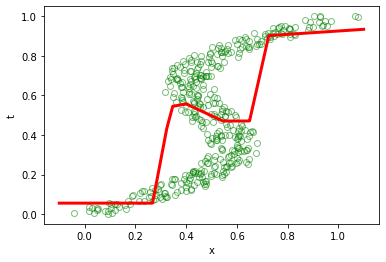

In [39]:
# plot
fig = plt.figure(figsize=(6, 4))
plt.plot(t_train_inv[:400], x_train_inv[:400], 'go', alpha=0.5, markerfacecolor='none')
plt.plot(t_test_inv, out.data, 'r', linewidth=3.0)
plt.xlabel('x')
plt.ylabel('t')
# plt.savefig("data_prob_fit.png", dpi=200)
plt.show()

The predictions look just like the ones for the Mean-Squared-Error loss.
<img src="./data_prob_fit.png" alt="drawing" width="400"/> 

Estimating only the mean (fixing $\sigma$) is equivalent to training the neural network with the mean-squared error loss.  
$L = \sum_i (t_i - \mu(x_i))^2$  

Training this neural network converges to the conditional mean: $\mu(x_i) \rightarrow E[t_i | x_i]$ (proof in Bishop 1994).  

<img src="./data1_fit.png" alt="drawing" width="400"/> 

## How can we fix this behavior?

So far, we assumed a certain standard deviation. From the previous slides:

In [40]:
s = torch.tensor([2.0]) # Standard deviation, assumed.

Instead, let's also learn this parameter.

In [41]:
def train(x, y):
    dataset = data.TensorDataset(x, y)
    train_loader = data.DataLoader(
        dataset, batch_size=20)
    
    net = nn.Sequential(
        nn.Linear(1, 20), nn.ReLU(),
        nn.Linear(20, 20), nn.ReLU(),
        nn.Linear(20, 2))
    
    opt = optim.Adam(net.parameters(), lr=0.01)
    for e in range(100):
        for x, y in train_loader:
            opt.zero_grad()
            out = net(x)
            m = out[:, 0].unsqueeze(1)
            s = torch.exp(out[:,1]).unsqueeze(1)
            prob_Gauss = 1/torch.sqrt(2*pi*s**2) * torch.exp(-.5/s**2*(m-y)**2)
            loss = -torch.log(prob_Gauss).sum()
            loss.backward()
            opt.step()
            
    return net

In [43]:
# net = train(t_train_inv, x_train_inv)

In [44]:
# torch.save(net, 'prob_std_net')

In [46]:
net = torch.load('nets/prob_std_net')

We now have a probabilistic model.<br/>  
<br/>
It outputs the parameters of a probability density distribution.<br/>  
<br/>
In this case, it was a Gaussian distribution of which we learned the mean and standard deviation.<br/>  
<br/>
To evaluate the result, we can look at samples from the returned distribution.<br/>  

In [47]:
samples = []
x_test_inv = torch.linspace(-0.1, 1.1, 500).unsqueeze(1)

for single_x in x_test_inv:
    network_outs = net(single_x.unsqueeze(1))
    m = network_outs[:,0]
    s = torch.exp(network_outs[:,1])
    conditional_distribution = Normal(m, s)
    sample = conditional_distribution.sample((1,))
    
    samples.append(sample)
samples = torch.cat(samples).data

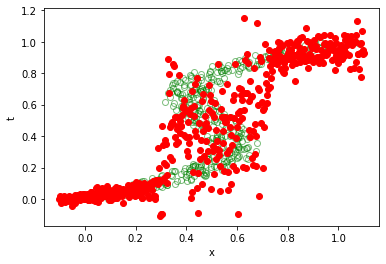

In [48]:
# plot
fig = plt.figure(figsize=(6, 4))
plt.plot(t_train_inv[:400], x_train_inv[:400], 'go', alpha=0.5, markerfacecolor='none')
plt.plot(t_test_inv, samples.squeeze().detach(), 'ro', linewidth=3.0)
plt.xlabel('x')
plt.ylabel('t')
# plt.savefig("data_prob_std_fit.png", dpi=200)
plt.show()

<img src="./data_prob_std_fit.png" alt="drawing" width="400"/> 
The network now also returns an estimate of the uncertainty for any input $x$.<br/> 
<br/>
Note that the uncertainty can vary for different inputs $x$.

## Mixture Density Networks

<img src="./architecture.png" alt="drawing" width="600"/>

The loss is now the probability under this mixture of Gaussians  <br/>

$L = -\sum_i \log p(t_i) = -\sum_i \log \sum_j \alpha_{j,i} N(t_i; \mu_{j,i}, \sigma_{j,i})$  <br/>

We learn the mixture components $\alpha_j$, the means $\mu_j$, and the variances $\sigma_j$.

In [49]:
def merge_leading_dims(x, num_dims):
    """Reshapes the tensor `x` such that the first `num_dims` dimensions are merged to one."""
    new_shape = torch.Size([-1]) + x.shape[num_dims:]
    return torch.reshape(x, new_shape)

def repeat_rows(x, num_reps):
    """Each row of tensor `x` is repeated `num_reps` times along leading dimension."""
    shape = x.shape
    x = x.unsqueeze(1)
    x = x.expand(shape[0], num_reps, *shape[1:])
    return merge_leading_dims(x, num_dims=2)

In [50]:
class MultivariateGaussianMDN(nn.Module):
    """For a documented version of this code, see: 
    https://github.com/mackelab/pyknos/blob/main/pyknos/mdn/mdn.py"""
    
    def __init__(
        self, features, context_features,
        hidden_features, hidden_net,
        num_components, custom_initialization=False,
        embedding_net=None,
    ):
        # ...
        self.net = hidden_net
        super().__init__()

    def get_mixture_components(self, context):
        # Pass through neural network...
        return alphas, means, covs

    def log_prob(self, inputs, context):
        alphas, means, covs = get_mixture_components(context)
        # Evaluate the probability of `inputs` under every component of the Mixture of Gaussians.
        # Then sum the probabilities...
        return log_prob

    def sample(self, num_samples, context):
        alpha, means, cov = get_mixture_components(context)
        # Sample from the Mixture of Gaussians. First, select a component, then sample from it...
        return samples

In [432]:
class MultivariateGaussianMDN(nn.Module):
    """
    For a documented version of this code, see: 
    https://github.com/mackelab/pyknos/blob/main/pyknos/mdn/mdn.py
    """

    def __init__(
        self,
        features,
        hidden_net,
        num_components,
        hidden_features,
    ):

        super().__init__()

        self._features = features
        self._num_components = num_components
        
        self._hidden_net = hidden_net
        self._logits_layer = nn.Linear(hidden_features, num_components)
        self._means_layer = nn.Linear(hidden_features, num_components * features)
        self._unconstrained_diagonal_layer = nn.Linear(
            hidden_features, num_components * features
        )

    def get_mixture_components(
        self, context
    ):
        h = self._hidden_net(context)

        logits = self._logits_layer(h)
        logits = logits - torch.logsumexp(logits, dim=1).unsqueeze(1)
        means = self._means_layer(h).view(-1, self._num_components, self._features)

        log_variances = self._unconstrained_diagonal_layer(h).view(
            -1, self._num_components, self._features
        )
        variances = torch.exp(log_variances)

        return logits, means, variances

    def log_prob(self, theta, context):

        logits, means, variances = self.get_mixture_components(context)
        
        batch_size, n_mixtures, theta_dim = means.size()
        theta = theta.view(-1, 1, theta_dim)
        
        log_cov_det = -0.5*torch.log(torch.prod(variances, dim=2))

        a = logits
        b = -(theta_dim / 2.0) * np.log(2 * np.pi)
        c = log_cov_det
        d1 = theta.expand_as(means) - means
        precisions = 1.0 / variances
        val_of_mult = d1 * precisions * d1
        exponent = torch.sum(d1 * precisions * d1, dim=2)
        exponent = tensor(-0.5) * exponent
        
        return torch.logsumexp(a + b + c + exponent, dim=-1)

    def sample(self, context):

        logits, means, variances = self.get_mixture_components(context)
        batch_size, n_mixtures, output_dim = means.shape
        
        coefficients = F.softmax(logits, dim=-1)
        
        choices = torch.multinomial(
            coefficients, num_samples=1, replacement=True
        ).view(-1)

        chosen_means = means[:, choices, :]
        chosen_variances = variances[:, choices, :]

        standard_normal_samples = torch.randn(output_dim, 1)
        zero_mean_samples = standard_normal_samples * torch.sqrt(chosen_variances)
        samples = chosen_means + zero_mean_samples

        return samples

In [438]:
def train(x, y):
    dataset = data.TensorDataset(x, y)
    train_loader = data.DataLoader(
        dataset, batch_size=50,
    )
    mdn = MultivariateGaussianMDN(
        features=1,
        hidden_net=nn.Sequential(
            nn.Linear(1, 30),
            nn.ReLU(),
            nn.Linear(30, 30),
            nn.ReLU(),
            nn.Linear(30, 30),
            nn.ReLU(),
        ),
        num_components=5,
        hidden_features=30,
    )
    opt = optim.Adam(mdn.parameters(), lr=0.001)
    for e in range(200):
        if e % 50 == 0:
            print("epoch", e)
        for x, y in train_loader:
            opt.zero_grad()
            out = mdn.log_prob(y, context=x)
            loss = -out.sum()
            loss.backward()
            opt.step()
            
    return mdn

In [439]:
mdn = train(t_train_inv, x_train_inv)

epoch 0
epoch 50
epoch 100
epoch 150


In [440]:
# torch.save(mdn, 'mdn_net')

In [441]:
# mdn = torch.load('nets/mdn_net')

## How do we evaluate the Mixture Density Network?
For every input, the output will be a Mixture of Gaussians. We can either sample from this mixture of evaluate the log-probability.

In [442]:
samples = []
x_test_inv = torch.linspace(-0.1, 1.1, 500).unsqueeze(1)
for single_x in x_test_inv:
    sample = mdn.sample(single_x.unsqueeze(0))
    samples.append(sample)
samples = torch.cat(samples).data

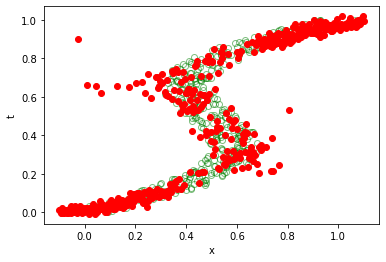

In [443]:
# plot
fig = plt.figure(figsize=(6, 4))
plt.plot(t_train_inv[:400], x_train_inv[:400], 'go', alpha=0.5, markerfacecolor='none')
plt.plot(t_test_inv, samples.squeeze().detach(), 'ro', linewidth=3.0)
plt.xlabel('x')
plt.ylabel('t')
plt.show()

## Summary: mixture density networks

<br/>
- Mixture density networks predict parameters of a mixture of Gaussians <br/>
<br/>
- Because of this, this can capture variability and multi-modality <br/>
<br/>
- To look at their predictions, one can either draw samples from the predicted mixture of Gaussians or evaluate the probability of the prediction

## Example from Neuroscience

Try to predict membrane conductances (Sodium and Potassium) from observed voltage trace (left). Ground truth in yellow, the prediction of the MDN in red.

<img src="./full_HH_fig.png" alt="drawing" width="600"/>

Picture credit to Pedro Gonçalves et al., Cosyne 2017

# What are the limitations?
<br/>
- One has to decide on hyperparameters: e.g. how many **components** (i.e. Gaussians) will I need? <br/>
<br/>
- Training often does not converge perfectly. <br/>
<br/>
- In practice, high-dimensional distributions might not be captured perfectly even with a high number of components. <br/>

# Other methods for density estimation

**Variational Autoencoders**  
Do not allow to evaluate the estimated density $q(t_i)$. Hence, maximum likelihood optimization is not possible. Instead, optimize a lower bound to it -- the ELBO.

**Generative Adversarial Networks**  
Again, they do not allow to evaluate the estimated density $q(t_i)$. This is bipassed with an adversarial objective.

**Normalizing flows**  
Neural networks that are designed such that the estimated density $q(t_i)$ can be evaluated. Thus, training is done with maximum likelihood.

All of these methods can easily be made conditional by e.g. adding $\text{NN}(x_i)$ to the parameters.

# Acknowledgments
<br/>
<br/>

Parts of the code from: https://mikedusenberry.com/mixture-density-networks  <br/>
Code of MDNs based on Conor Durkan's `lfi` package.  <br/>
Bishop, 1994  <br/>
[MDN graphic](https://towardsdatascience.com/a-hitchhikers-guide-to-mixture-density-networks-76b435826cca)
Pedro Gonçalves et al. for figure.